In this notebook, we apply an ARIMA ($\textbf{A}$uto$\textbf{R}$egressive $\textbf{I}$ntegrative $\textbf{M}$oving $\textbf{A}$verage) model to crypto data. A large amount of inspiration for this model was taken from https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70 and the Investopedia article.

In [1]:
# First, we read in our data.

import pandas as pd

df = pd.read_csv("data/crypto_data.csv")
df.head()

,date,high,low,open,close,volume,adjclose,formatted_date,coin
0,1546300800,3850.913818,3707.231201,3746.713379,3843.520020,4.324201e+09,3843.520020,2019-01-01,BTC-USD
1,1546387200,3947.981201,3817.409424,3849.216309,3943.409424,5.244857e+09,3943.409424,2019-01-02,BTC-USD
2,1546473600,3935.685059,3826.222900,3931.048584,3836.741211,4.530215e+09,3836.741211,2019-01-03,BTC-USD
3,1546560000,3865.934570,3783.853760,3832.040039,3857.717529,4.847965e+09,3857.717529,2019-01-04,BTC-USD
4,1546646400,3904.903076,3836.900146,3851.973877,3845.194580,5.137610e+09,3845.194580,2019-01-05,BTC-USD


In [2]:
coins = df['coin'].unique()
coins

array(['BTC-USD', 'ETH-USD', 'DOGE-USD', 'SOL1-USD', 'BNB-USD',
       'DOT1-USD', 'HEX-USD', 'ALGO-USD'], dtype=object)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


Much like the TowardsDataScience article, we target the $\textbf{close}$ column to predict for. We begin by performing some EDA - for the sake of simplicity, we simply target BTC-USD - plotting autocorrelations and the trend over time.

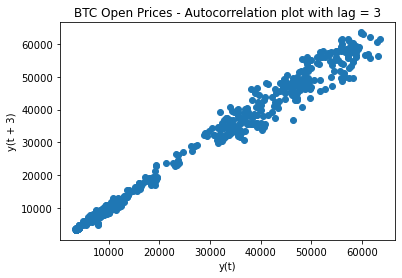

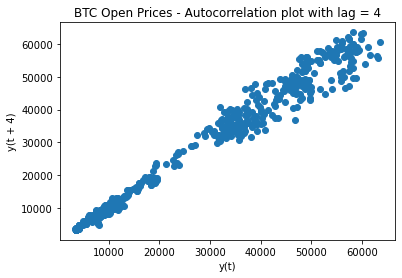

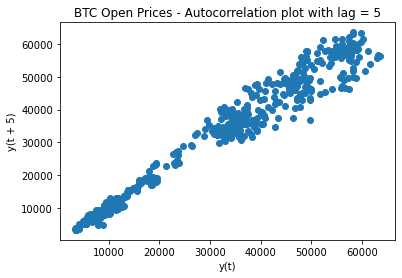

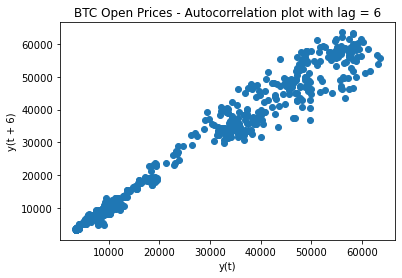

In [4]:
lags = range(3, 7)
for lag in lags:
    plt.figure()
    df_btc_opens = df.loc[df['coin'] == 'BTC-USD', 'open']
    lag_plot(df_btc_opens, lag=lag)
    plt.title('BTC Open Prices - Autocorrelation plot with lag = {}'.format(lag))
    plt.show()

Now, we train our actual ARIMA models. Since we use autocorrelations in ARIMA, we look at coins separately, and our mean-squared error is simply the mean squared error across all coins. We do an exhaustive hyperparameter search for the best values of $p$ and $d$.

In [ ]:
unique_coins = df['coin'].unique()
ps = range(2, 5)
ds = range(1, 3) # note that d = 0 is simply the ARMA model, d>2 is not supported
q = 0
train_fold = 0.8

for p in ps:
    for d in ds:
        coin_mses = []
        for coin in unique_coins:
            df_coin = df.loc[df['coin'] == coin, 'close']
            train_data_coin = df_coin[0: int(len(df_coin) * train_fold)].dropna().values
            coin_mean = train_data_coin.mean()
            coin_std = train_data_coin.std()
            train_data_coin = list(train_data_coin)
            test_data_coin_np = df_coin[int(len(df_coin) * train_fold): int(len(df_coin) * (train_fold + .2))].dropna().values
            test_data_coin = list(test_data_coin_np)
            coin_preds = []
            for time_point in range(len(test_data_coin)):
                model = ARIMA(train_data_coin, order=(p, d, q))
                model_fit = model.fit(disp=0)
                coin_preds.append((model_fit.forecast()[0] - coin_mean) / coin_std)
                truth = test_data_coin[time_point]
                train_data_coin.append(truth)
            coin_mses.append(mean_squared_error((test_data_coin_np - coin_mean) / coin_std, coin_preds))
        print('For p = {}, d = {}, q = {}, mean = {}'.format(str(p), str(d), str(q), str(np.array(coin_mses).mean())))


We see that $p = 2$, $d = 1$ performs best. We plot the prediction curves for the coins here:

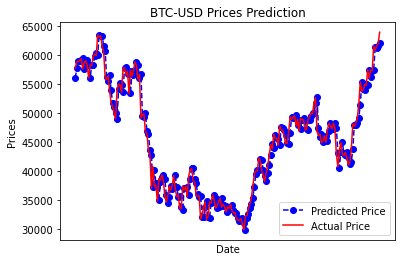

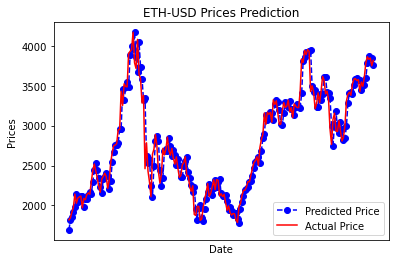

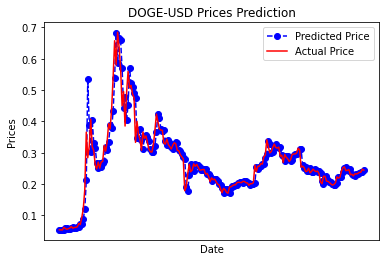

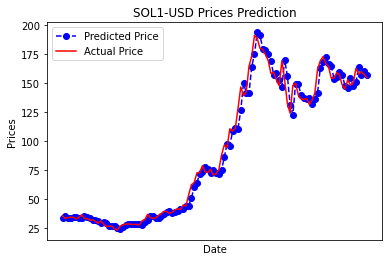

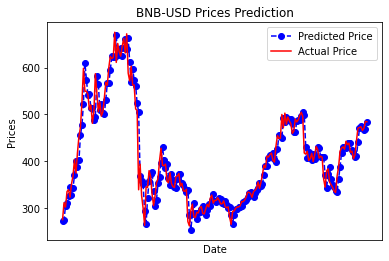

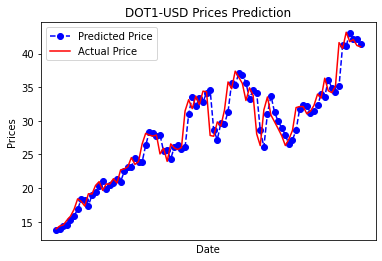

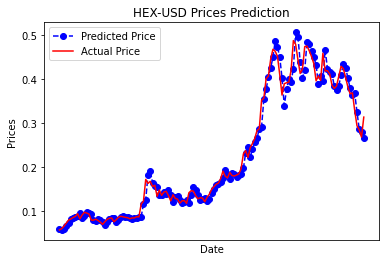

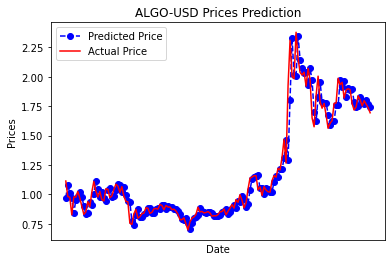

In [20]:
unique_coins = df['coin'].unique()
train_fold = 0.8
for coin in unique_coins:
    df_coin = df.loc[df['coin'] == coin, 'close']
    train_data_coin = list(df_coin[0: int(len(df_coin) * train_fold)].dropna().values)
    test_data_coin = list(df_coin[int(len(df_coin) * train_fold): int(len(df_coin) * (train_fold + .2))].dropna().values)
    coin_preds = []
    for time_point in range(len(test_data_coin)):
        model = ARIMA(train_data_coin, order=(2, 1, 0))
        model_fit = model.fit(disp=0)
        coin_preds.append(model_fit.forecast()[0])
        truth = test_data_coin[time_point]
        train_data_coin.append(truth)
    
    test_set_range = df_coin[int(len(df_coin)* train_fold):].index
    plt.plot(test_set_range, coin_preds, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(test_set_range, test_data_coin, color='red', label='Actual Price')
    plt.title('{} Prices Prediction'.format(coin))
    plt.xticks([], [])
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

Furthermore, we post the raw MSE scores between the coins and our model with the selected hyperparameters.

In [ ]:
unique_coins = df['coin'].unique()
train_fold = 0.8
for coin in unique_coins:
    df_coin = df.loc[df['coin'] == coin, 'close']
    train_data_coin = list(df_coin[0: int(len(df_coin) * train_fold)].dropna().values)
    test_data_coin = list(df_coin[int(len(df_coin) * train_fold): int(len(df_coin) * (train_fold + .2))].dropna().values)
    coin_preds = []
    for time_point in range(len(test_data_coin)):
        model = ARIMA(train_data_coin, order=(2, 1, 0))
        model_fit = model.fit(disp=0)
        coin_preds.append(model_fit.forecast()[0])
        truth = test_data_coin[time_point]
        train_data_coin.append(truth)
    print("MSE Loss for {}: {}".format(coin, ))